<H1> Etude de cas - Exploratory data analysis </H1>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prince
from sklearn import manifold 
import scipy 
from sklearn.cluster import KMeans

import scipy

import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.optimizers import SGD


%matplotlib inline
# import cufflinks as cf
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True) # connect notebook to javascript engine

import warnings
warnings.filterwarnings('ignore')

In [2]:
# cf.go_offline()

<H3> Loading and arranging data set </H3>

In [3]:
data = pd.read_csv('final_df.csv')
data.drop(columns=['Unnamed: 0','idn.lieu'], inplace=True)
data.rename(columns={'Formldehyde':'Formaldehyde'}, inplace=True)
data.head()

,Deodorants.ICOS1,EauDeToilette.ICOS2,ProdSoinCheveux.ICOS3,ProdSoinVisage.ICOS4,VernisOngleDissolv.ICOS5,DesodoAutreEnsens.QPD2b,ACTIVITE,VoitureDansGarage.DGG3n,Fumeurs.FUMEURn,Plantes.QPV,...,benzene,1-methoxy-2-propanol,trichloroethylene,toluene,tetrachloroethylene,styrene,2-butoxy,ethanol,124-trimethylbenzene,4-dichlorobenzene
0,10.5,14.0,0.0,7.0,0.0,0.0,3.15,4,3,1,...,1.34,0.24,0.27,5.12,0.45,0.31,0.38,0.88,1.06,1.15
1,14.0,14.0,1.0,7.0,0.5,0.0,5.25,4,2,2,...,1.20,0.25,0.50,15.74,0.79,0.32,1.00,1.57,0.85,2.23
2,7.0,7.0,0.0,7.0,0.0,0.0,2.35,4,1,1,...,0.86,4.08,0.30,4.72,0.48,0.38,0.51,1.21,0.71,0.83
3,0.0,1.0,0.5,7.0,1.0,0.0,2.10,4,1,1,...,0.72,0.65,0.26,2.74,8.05,0.21,2.30,1.36,4.52,0.67
4,14.0,10.5,10.5,7.0,0.0,7.0,7.00,4,2,2,...,1.16,3.51,0.09,3.46,0.09,0.76,0.00,0.78,6.22,3.65


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 44 columns):
Deodorants.ICOS1                     530 non-null float64
EauDeToilette.ICOS2                  530 non-null float64
ProdSoinCheveux.ICOS3                530 non-null float64
ProdSoinVisage.ICOS4                 530 non-null float64
VernisOngleDissolv.ICOS5             530 non-null float64
DesodoAutreEnsens.QPD2b              530 non-null float64
ACTIVITE                             530 non-null float64
VoitureDansGarage.DGG3n              530 non-null int64
Fumeurs.FUMEURn                      530 non-null int64
Plantes.QPV                          530 non-null int64
TraitementParasitesAnimaux.ANTCPn    530 non-null int64
SortirOrduresExterieur.QOM1          530 non-null int64
Bricolage.TMG6n                      530 non-null int64
Jardinage.TMG7n                      530 non-null int64
Age                                  530 non-null int64
Revenus                              530 

- Data is composed by 530 observations (after dropping all N/A) rows
- In total we have 44 variables: 23 numerical (including 14 toxic chemicals, age, revenues, and 7 habit coefficients)
- The rest of variables are categorical (type integer). 

<H3> Analysis of Quantitative variables</H3>
We are going to analyse the Aldehyde family in relation to other quantitative variables related to quantitative conductual variables:
- The frequency of use of personal care products, home care chemicals and activity (nobody knows what it is)

In [5]:
# define a lis of names or quantitative variables
# num_var = 'Age Deodorants.ICOS1 EauDeToilette.ICOS2 ProdSoinCheveux.ICOS3 ProdSoinVisage.ICOS4 VernisOngleDissolv.ICOS5 DesodoAutreEnsens.QPD2b ACTIVITE Formaldehyde acetaldehyde hexaldehyde'.split()  
# pca = prince.PCA(data[num_var], n_components=2)
# pca.plot_rows()

In [6]:
# pca.plot_correlation_circle()

- The acetaldehyde family seems to be responsible of most of the variance on the PC2 axe. We have a low interia in our representation, that can suggest non-linear relationships and manifold entangling. it's possible to apply t-SNE to get a better visualization.
- There is not a considerable linear correlation between conductual habits and the increase of haldeydes concentration.
- From the family of aldehydes, can react with human AND and produce cancer.  We're going to explain the most dangerous 'Formaldehyde'.

In [7]:
# corr_matrix = data[num_var].corr()
# sns.heatmap(corr_matrix)

<H3> Formaldehyde concentration analysis </H3>

In [8]:
# dropping al chemicals except Formaldehyde
drop_list = 'acetaldehyde acroleine hexaldehyde benzene 1-methoxy-2-propanol trichloroethylene toluene tetrachloroethylene styrene 2-butoxy ethanol 124-trimethylbenzene 4-dichlorobenzene'.split()  
#drop_list = 'acroleine benzene 1-methoxy-2-propanol trichloroethylene toluene tetrachloroethylene styrene 2-butoxy ethanol 124-trimethylbenzene 4-dichlorobenzene'.split()  
data.drop(columns=drop_list, inplace=True)

<H3> Converting Formaldehyde to categorical </H3>

In [9]:
def formaldehyde_cat_int(x):
    """Function to convert Formaldehyde concentrations 
    to a categorical variable type int64"""
    
    if (x < 11.70):
        x = 1    # low
    elif ((x >= 11.70) & (x < 23.63)):
        x = 2   # intermediate
    elif ((x >= 23.63) & (x < 40)):
        x = 3 # high
    else:
        x = 4 # very high
    return x

def formaldehyde_cat_str(x):
    """Function to convert Formaldehyde concentrations 
    to a categorical variable type string"""
    
    if (x < 11.70):
        x = 'low'
    elif ((x >= 11.70) & (x < 23.63)):
        x = 'intermediate'
    elif ((x >= 23.63) & (x < 40)):
        x = 'high'
    else:
        x = 'very high'
    return x

# applying the function
data['class'] = data['Formaldehyde'].apply(formaldehyde_cat_str)
data['class_int'] = data['Formaldehyde'].apply(formaldehyde_cat_int)

In [10]:
# sns.boxplot(x='class',
#             y = 'Formaldehyde',
#             data=data,
#            palette = 'rainbow'
#            )

In [11]:
# data[['Formaldehyde','class']].groupby('class').describe()

<H3> Conver all numerical variables to categorical </H3>

In [12]:
def activite_cat(x):
    """Function to convert Formaldehyde concentrations 
    to a categorical variable"""
    
    if (x < 3.67):
        x = 1 #'low'
    elif ((x >= 3.67) & (x < 5.55)):
        x = 2 #'intermediate'
    else:
        x = 3 #'high'
    return x

# user functions to convert to categorical
def age_cat(x):
    if (x < 25):
        x = 1 #'under 25s'
    elif ((x >= 25) & (x < 45)):
        x = 2 #'25 to 45s'
    elif ((x >= 45) & (x < 65)):
        x = 3 #'45 to 65s'
    else:
        x = 4 #'over 65s'
    return x

def hsrf_cat(x, box):
    if (x <= box[4]):
        x = 1 #'small'
    elif (x >= box[6]):
        x = 2 #'large'
    else:
        x = 3 #'medium'
    return x
    
def years_cat(x):
    if (x < 1948):
        x = 1 #'before 1948'
    elif ((x >= 1948) & (x < 1967)):
        x = 2# '1948 to 1967'
    elif ((x >= 1967) & (x < 1989)):
        x = 3 #'1967 to 1989'
    else:
        x = 4 #'after 1989'
    return x

def revenus_cat(x):
    if (x <= 1299):
        x = 1 #'low'
    elif ((x > 1299) & (x < 2350)):
        x = 2# 'moderated'
    elif ((x >= 2350) & (x < 4300)):
        x = 3 #'high'
    else:
        x = 4 #'very high'
    return x

# applying functions in place
# revenus
data['Revenus'] = data['Revenus'].apply(revenus_cat)
# age
data['Age'] = data['Age'].apply(age_cat)
# housing area
box = data['HSRF'].describe()
data['HSRF'] = data['HSRF'].apply(hsrf_cat,args = (box,))
# year of construction
data['NIACe1'] = data['NIACe1'].apply(years_cat)
# activity
data['ACTIVITE'] = data['ACTIVITE'].apply(activite_cat)

<H3> Converting behavioural numerical variabes </H3>
<strong> please check this function, perhaps is not the best categorization </strong>

In [13]:
def behavioural_cat(x,box):
    if (x < box[4]):
        x = 1 #'low'
    elif ((x >= box[4]) & (x < box[1])):
        x = 2 #'intermediate'
    elif ((x >= box[1]) & (x < box[6])):
        x = 3 #'high'
    else:
        x = 4 #'very high'
    return x

# behavioural variables to convert
var_names = 'Deodorants.ICOS1 EauDeToilette.ICOS2 ProdSoinCheveux.ICOS3 ProdSoinVisage.ICOS4 VernisOngleDissolv.ICOS5 DesodoAutreEnsens.QPD2b'.split()

for name in data[var_names].columns:
    box = data[name].describe()
    data[name] = data[name].apply(behavioural_cat,args = (box,))

In [14]:
# keeping auxiliar labels
labels_str = data['class']
labels_int = data['class_int']
form_values = data['Formaldehyde']

# dropping and renaming
# data.drop(columns=['Formaldehyde','class_int'], inplace=True)
data.drop(columns=['Formaldehyde','class'], inplace=True)
data.rename(columns={'class_int':'Formaldehyde'}, inplace=True)

In [15]:
data.head()

,Deodorants.ICOS1,EauDeToilette.ICOS2,ProdSoinCheveux.ICOS3,ProdSoinVisage.ICOS4,VernisOngleDissolv.ICOS5,DesodoAutreEnsens.QPD2b,ACTIVITE,VoitureDansGarage.DGG3n,Fumeurs.FUMEURn,Plantes.QPV,...,Type_Prof,Occupation,Source_ppale_Res,Structure_menage,HSRF,NIACe1,CHEM1,DCA3e1,FC316,Formaldehyde
0,3,4,2,2,2,2,1,4,3,1,...,6,1,1,3,1,1,1,3,1,2
1,4,4,2,2,2,2,2,4,2,2,...,4,1,1,2,1,2,1,3,1,1
2,2,2,2,2,2,2,1,4,1,1,...,5,1,1,1,1,1,1,3,1,2
3,1,1,2,2,2,2,1,4,1,1,...,3,1,1,2,3,3,1,3,1,1
4,4,3,4,2,2,4,3,4,2,2,...,6,1,1,3,1,3,1,2,1,2


In [16]:
data

,Deodorants.ICOS1,EauDeToilette.ICOS2,ProdSoinCheveux.ICOS3,ProdSoinVisage.ICOS4,VernisOngleDissolv.ICOS5,DesodoAutreEnsens.QPD2b,ACTIVITE,VoitureDansGarage.DGG3n,Fumeurs.FUMEURn,Plantes.QPV,...,Type_Prof,Occupation,Source_ppale_Res,Structure_menage,HSRF,NIACe1,CHEM1,DCA3e1,FC316,Formaldehyde
0,3,4,2,2,2,2,1,4,3,1,...,6,1,1,3,1,1,1,3,1,2
1,4,4,2,2,2,2,2,4,2,2,...,4,1,1,2,1,2,1,3,1,1
2,2,2,2,2,2,2,1,4,1,1,...,5,1,1,1,1,1,1,3,1,2
3,1,1,2,2,2,2,1,4,1,1,...,3,1,1,2,3,3,1,3,1,1
4,4,3,4,2,2,4,3,4,2,2,...,6,1,1,3,1,3,1,2,1,2
5,1,2,2,1,2,2,1,4,1,1,...,6,1,1,1,1,2,1,3,1,2
6,2,2,2,2,2,2,1,4,1,1,...,7,3,5,1,1,2,1,3,1,2
7,4,4,2,4,2,2,3,4,3,1,...,5,5,1,4,3,3,1,2,1,3
8,4,1,2,2,2,2,1,4,1,3,...,4,4,3,3,3,3,1,2,1,1
9,2,1,2,3,2,2,1,4,3,1,...,3,4,3,3,3,4,1,2,1,2


<H3> Converting all columns to categorical <H3>

In [17]:
data_cat = data

for name in data_cat.columns:
    data_cat[name] = data_cat[name].astype('category')
    
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 31 columns):
Deodorants.ICOS1                     530 non-null category
EauDeToilette.ICOS2                  530 non-null category
ProdSoinCheveux.ICOS3                530 non-null category
ProdSoinVisage.ICOS4                 530 non-null category
VernisOngleDissolv.ICOS5             530 non-null category
DesodoAutreEnsens.QPD2b              530 non-null category
ACTIVITE                             530 non-null category
VoitureDansGarage.DGG3n              530 non-null category
Fumeurs.FUMEURn                      530 non-null category
Plantes.QPV                          530 non-null category
TraitementParasitesAnimaux.ANTCPn    530 non-null category
SortirOrduresExterieur.QOM1          530 non-null category
Bricolage.TMG6n                      530 non-null category
Jardinage.TMG7n                      530 non-null category
Age                                  530 non-null category
Revenus   

In [18]:
data_cat.head()

,Deodorants.ICOS1,EauDeToilette.ICOS2,ProdSoinCheveux.ICOS3,ProdSoinVisage.ICOS4,VernisOngleDissolv.ICOS5,DesodoAutreEnsens.QPD2b,ACTIVITE,VoitureDansGarage.DGG3n,Fumeurs.FUMEURn,Plantes.QPV,...,Type_Prof,Occupation,Source_ppale_Res,Structure_menage,HSRF,NIACe1,CHEM1,DCA3e1,FC316,Formaldehyde
0,3,4,2,2,2,2,1,4,3,1,...,6,1,1,3,1,1,1,3,1,2
1,4,4,2,2,2,2,2,4,2,2,...,4,1,1,2,1,2,1,3,1,1
2,2,2,2,2,2,2,1,4,1,1,...,5,1,1,1,1,1,1,3,1,2
3,1,1,2,2,2,2,1,4,1,1,...,3,1,1,2,3,3,1,3,1,1
4,4,3,4,2,2,4,3,4,2,2,...,6,1,1,3,1,3,1,2,1,2


In [19]:
# CAH
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
# generate the linkage matrix
# 'single', 'complete', 'average', 'ward'
Z = linkage(data_cat, 'ward')
# Z = linkage(data_cat, 'average')
# Z = linkage(data_cat, 'complete')
# Z = linkage(data_cat, 'single')

In [20]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [21]:
c, coph_dists = cophenet(Z, pdist(data_cat, metric='euclidean'))
c

0.44334255028152325

In [22]:
Z[:20]

array([[ 290.     ,  476.     ,    1.     ,    2.     ],
       [   2.     ,  525.     ,    2.     ,    2.     ],
       [  58.     ,  374.     ,    2.     ,    2.     ],
       [  82.     ,  317.     ,    2.23607,    2.     ],
       [ 110.     ,  473.     ,    2.23607,    2.     ],
       [ 176.     ,  517.     ,    2.23607,    2.     ],
       [   5.     ,  303.     ,    2.44949,    2.     ],
       [   6.     ,  514.     ,    2.44949,    2.     ],
       [ 294.     ,  533.     ,    2.64575,    3.     ],
       [ 116.     ,  282.     ,    2.64575,    2.     ],
       [ 115.     ,  228.     ,    2.64575,    2.     ],
       [ 216.     ,  388.     ,    2.64575,    2.     ],
       [  38.     ,  406.     ,    2.64575,    2.     ],
       [ 298.     ,  434.     ,    2.64575,    2.     ],
       [  10.     ,  280.     ,    2.82843,    2.     ],
       [ 509.     ,  523.     ,    3.     ,    2.     ],
       [ 109.     ,  304.     ,    3.16228,    2.     ],
       [ 103.     ,  430.     ,

In [23]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

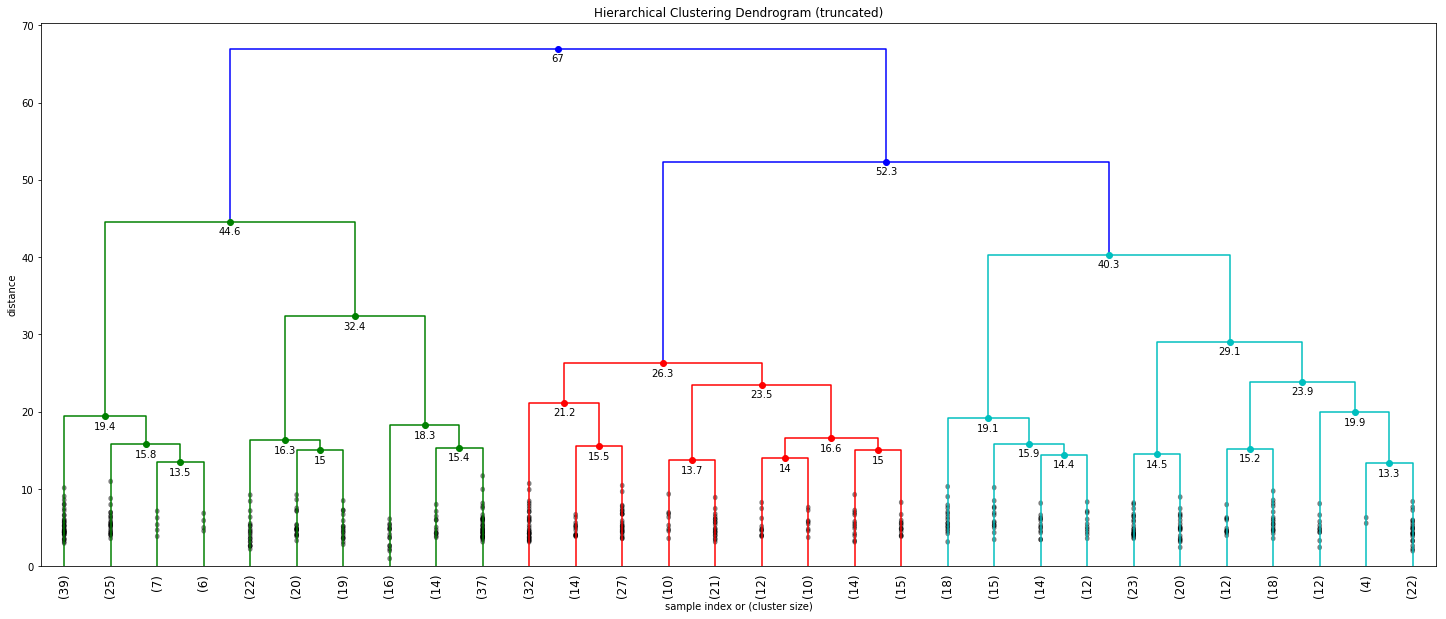

In [24]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
)
plt.show()

In [25]:
k=4
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([4, 3, 2, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 3, 4, 2, 3, 3, 2, 4, 2, 3, 3,
       4, 2, 4, 4, 3, 3, 4, 1, 3, 1, 2, 1, 1, 4, 2, 2, 4, 3, 2, 4, 1, 1, 2,
       3, 2, 3, 3, 1, 4, 4, 2, 3, 3, 4, 3, 4, 1, 2, 4, 3, 4, 2, 3, 4, 3, 3,
       1, 2, 3, 2, 1, 4, 4, 3, 1, 4, 4, 3, 4, 2, 3, 3, 2, 4, 3, 4, 3, 4, 3,
       4, 4, 4, 4, 3, 2, 1, 3, 4, 3, 4, 2, 3, 4, 3, 4, 2, 3, 4, 2, 1, 4, 3,
       2, 2, 4, 3, 2, 4, 3, 2, 4, 4, 1, 4, 1, 3, 4, 2, 3, 4, 1, 4, 4, 3, 4,
       4, 4, 3, 1, 2, 3, 4, 3, 3, 1, 4, 2, 1, 2, 4, 3, 4, 4, 4, 3, 4, 4, 4,
       4, 3, 4, 2, 3, 3, 2, 4, 3, 4, 3, 4, 1, 4, 1, 2, 3, 3, 3, 3, 1, 2, 4,
       3, 3, 1, 3, 4, 4, 3, 1, 3, 3, 2, 3, 1, 3, 4, 3, 4, 3, 4, 3, 2, 2, 1,
       1, 3, 4, 3, 3, 3, 1, 3, 3, 4, 2, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 2, 4,
       4, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 1, 3, 1, 2, 1, 1, 3, 2, 4, 1, 4, 4,
       2, 2, 4, 3, 3, 1, 2, 2, 3, 2, 2, 3, 2, 1, 3, 3, 1, 3, 3, 4, 3, 3, 2,
       2, 4, 4, 2, 2, 2, 2, 2, 1, 4, 2, 2, 3, 4, 2, 4, 4, 3, 2, 2, 4, 4, 2,
       4, 3,

In [26]:
# Preserving data_cat data set (prince MCA method do changes 'inplace')
data_cat2 = data_cat
data_cat2['cluster'] = clusters
data_cat2.head()

,Deodorants.ICOS1,EauDeToilette.ICOS2,ProdSoinCheveux.ICOS3,ProdSoinVisage.ICOS4,VernisOngleDissolv.ICOS5,DesodoAutreEnsens.QPD2b,ACTIVITE,VoitureDansGarage.DGG3n,Fumeurs.FUMEURn,Plantes.QPV,...,Occupation,Source_ppale_Res,Structure_menage,HSRF,NIACe1,CHEM1,DCA3e1,FC316,Formaldehyde,cluster
0,3,4,2,2,2,2,1,4,3,1,...,1,1,3,1,1,1,3,1,2,4
1,4,4,2,2,2,2,2,4,2,2,...,1,1,2,1,2,1,3,1,1,3
2,2,2,2,2,2,2,1,4,1,1,...,1,1,1,1,1,1,3,1,2,2
3,1,1,2,2,2,2,1,4,1,1,...,1,1,2,3,3,1,3,1,1,2
4,4,3,4,2,2,4,3,4,2,2,...,1,1,3,1,3,1,2,1,2,3


In [27]:

# mca = prince.MCA(data_cat2, n_components=-1)
# mca.plot_rows(show_points=True, show_labels=False, color_by='cluster', ellipse_fill=True)
# mca.plot_rows_columns()

In [30]:
# write clusters out the file
data_cat3 = pd.DataFrame()
data_cat3['cluster'] = clusters
data_cat3.to_csv('clusters.csv', sep=',')

In [ ]:
# # evaluate cluster
# from sklearn.metrics import silhouette_score

# data_cat_array = data_cat.values

# # Evaluate model
# silhouette_score(data_cat_array, clusters)

# WRONG - NEED to use predicted classes, not clusters. 
# To predict classes, take majority class in each cluster, and assign to all members